In [1]:
import matplotlib.pyplot as plt
import neurokit2 as nk
from tqdm import tqdm
import pandas as pd
import numpy as np
import h5py

import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset, random_split

In [2]:
device = 'cpu'

In [33]:
class Encoder(nn.Module):
    def __init__(self, n_features, embedding_dim=64):
        super(Encoder, self).__init__()
        
        self.n_features = n_features
        self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim
        
        self.rnn1 = nn.LSTM(
            input_size=n_features,
            hidden_size=self.hidden_dim,
            num_layers=1,
            batch_first=True
        )

        self.rnn2 = nn.LSTM(
            input_size=self.hidden_dim,
            hidden_size=embedding_dim,
            num_layers=1,
            batch_first=True
        )

    def forward(self, x):
        x, (hidden_n1, cell_n1) = self.rnn1(x)
        x, (hidden_n2, cell_n2) = self.rnn2(x)
        
        return x, (hidden_n1, cell_n1), (hidden_n2, cell_n2)

class Decoder(nn.Module):
    def __init__(self, input_dim=64, n_features=1):
        super(Decoder, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim, self.n_features = 2 * input_dim, n_features
        
        self.rnn1 = nn.LSTM(
            input_size=input_dim,
            hidden_size=input_dim,
            num_layers=1,
            batch_first=True
        )
        
        self.rnn2 = nn.LSTM(
            input_size=input_dim,
            hidden_size=self.hidden_dim,
            num_layers=1,
            batch_first=True
        )
        self.output_layer = nn.Linear(self.hidden_dim, n_features)
    
    def forward(self, x, hc1, hc2, seq_len):
        # x = torch.zeros((self.n_features, seq_len, self.input_dim))
        
        x, (hidden_n2, cell_n2) = self.rnn1(x)
        x, (hidden_n1, cell_n1) = self.rnn2(x)

        x = x.reshape((seq_len, self.hidden_dim))

        return self.output_layer(x)

    def old_forward(self, x, seq_len):
        x = x.repeat(seq_len, self.n_features)
        x = x.reshape((self.n_features, seq_len, self.input_dim))
        
        x, (hidden_n, cell_n) = self.rnn1(x)
        x, (hidden_n, cell_n) = self.rnn2(x)
        
        x = x.reshape((seq_len, self.hidden_dim))

        return self.output_layer(x)

class RecurrentAutoencoder(nn.Module):
    def __init__(self, n_features, embedding_dim=64):
        super(RecurrentAutoencoder, self).__init__()
    
        self.encoder = Encoder(n_features, embedding_dim).to(device)
        self.decoder = Decoder(embedding_dim, n_features).to(device)
    
    def eval_forward(self, x):
        seq_len = x.shape[1]

        x, hc1, hc2 = self.encoder(x)
        x = self.decoder(x, (torch.zeros(hc1[0].shape), torch.zeros(hc1[1].shape)), (torch.zeros(hc2[0].shape), torch.zeros(hc2[1].shape)), seq_len)
        
        return x

    def forward(self, x):
        seq_len = x.shape[1]

        x, hc1, hc2 = self.encoder(x)
        x = self.decoder(x, hc1, hc2, seq_len)
        
        return x

    def old_forward(self, x):
        seq_len = x.shape[2]
        x = self.encoder(x)
        x = self.decoder(x, seq_len)
        
        return x

In [4]:
def load_data_kaggle(metadata_filepath, sample_freq, N_start=0, N_end=10, only_health=False):
    """Загрузка данных из файлов.\n
    Работает только при наличии директории 'records',\n
    в которой пять папок по 5000 файлов записей"""
    
    # Загружаем метаданные и выбираем срезом нужные
    metadata_full = pd.read_csv('/kaggle/input/metadata/metadata.csv')
    metadata = metadata_full.iloc[N_start:N_end]

    # Убираем лишние столбцы, приводим к типу int32
    metadata = metadata.drop(columns=['Date', 'Patient_ID'])
    metadata['Age'].astype(np.int32)
    metadata['N'].astype(np.int32)


    if only_health:
        # Берём только здоровых людей
        health_metadata = metadata.loc[metadata['AHA_Code'] == '1']
        id_metadata = health_metadata['ECG_ID'].values
        labels = health_metadata['AHA_Code'].values
    else:
        # Берём всех
        id_metadata = metadata['ECG_ID'].values
        labels = metadata['AHA_Code'].values

    signals = []

    for i in id_metadata:
        # Из Axxxxx оставляем численную часть
        number = int(i[1:])
     
        # Считываем файл.
        with h5py.File(f'/kaggle/input/ecgdata/records/{i}.h5', 'r') as f:
            signals.append(f['ecg'][()])
    
    health_n = len(labels[labels == '1'])
    diseased_n = len(labels[labels != '1'])

    print(f"Data loaded successfully.\n\
          Health    number:     {health_n}\n\
          Diseased  number:     {diseased_n}\n\n")
    return signals, labels

def load_data(metadata_filepath, sample_freq, N_start=0, N_end=10, only_health=False):
    """Загрузка данных из файлов.\n
    Работает только при наличии директории 'records',\n
    в которой пять папок по 5000 файлов записей"""
    
    # Загружаем метаданные и выбираем срезом нужные
    metadata_full = pd.read_csv('metadata.csv')
    metadata = metadata_full.iloc[N_start:N_end]

    # Убираем лишние столбцы, приводим к типу int32
    metadata = metadata.drop(columns=['Date', 'Patient_ID'])
    metadata['Age'].astype(np.int32)
    metadata['N'].astype(np.int32)


    if only_health:
        # Берём только здоровых людей
        health_metadata = metadata.loc[metadata['AHA_Code'] == '1']
        id_metadata = health_metadata['ECG_ID'].values
        labels = health_metadata['AHA_Code'].values
    else:
        # Берём всех
        id_metadata = metadata['ECG_ID'].values
        labels = metadata['AHA_Code'].values

    signals = []

    for i in id_metadata:
        # Из Axxxxx оставляем численную часть
        number = int(i[1:])

        # В каждой папке 5000 файлов (кроме пятой), поэтому,
        # чтобы узнать номер папки, в которой запись, делим на 5000
        record_num = (number - 1) // 5000
        if record_num > 4:
            record_num = 4
        record_num = record_num + 1
        
        # Считываем файл.
        with h5py.File(f'records/record{record_num}/{i}.h5', 'r') as f:
            signals.append(f['ecg'][()])
    
    health_n = len(labels[labels == '1'])
    diseased_n = len(labels[labels != '1'])

    print(f"Data loaded successfully.\n\
          Health    number:     {health_n}\n\
          Diseased  number:     {diseased_n}\n\n")

    return signals, labels

def signal_transform_tensor_1(signals, N=0, max_len_signal=5000, sampling_rate=500):
    """Транформирует сигналы в тензор.\n
    N - номер отведения в соответствии с массивом:\n
    ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']"""

    # Ограничиваем максимальную длину до единого значения для использования в батче.
    # Дописывать нули в конце для одной длины - сомнительная идея для LSTM.

    i = 0

    result_reshape = np.reshape([[float(ss) for ss in signal[i][0:max_len_signal]] for signal in signals], (1, max_len_signal * len(signals)))

    return torch.tensor(result_reshape, dtype=torch.float32).reshape((1, len(signals), max_len_signal)).permute((1,2,0))

def signal_transform_tensor_12_scaled(signals, N=0, max_len_signal=5000, sampling_rate=500):
    """Транформирует сигналы в тензор.\n
    N - номер отведения в соответствии с массивом:\n
    ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']"""

    # Ограничиваем максимальную длину до единого значения для использования в батче.
    # Дописывать нули в конце для одной длины - сомнительная идея для LSTM.

    results_reshape = []

    scaler = MinMaxScaler()
    for i in range(12):
        # results_reshape.append(np.reshape([nk.ecg_clean(signal[i][0:max_len_signal], sampling_rate=sampling_rate) for signal in signals], (1, max_len_signal * len(signals))))
        s = [scaler.fit_transform(signal[i][0:max_len_signal].reshape(-1, 1)).reshape(max_len_signal) for signal in signals]
        
        results_reshape.append(np.reshape(s, (1, max_len_signal * len(signals))))

    result_reshape = np.concatenate(results_reshape)

    return torch.tensor(result_reshape, dtype=torch.float32).reshape((12, len(signals), max_len_signal)).permute((1,2,0))

def label_transform_tensor(labels, all_diagnoses=False):
    """Транформирует лейблы в тензор.\n
    Сейчас только в режиме 'Норма-Не норма'."""

    # TODO: сделать разбиение лейблов на первичное и вторичное заключение врача

    result_labels = []

    if all_diagnoses:
        return None
    
    else:
        # Норма - Не норма
        for label in labels:
            if label == '1':
                result_labels.append(0)
            else:
                result_labels.append(1)

    result_labels = torch.tensor(result_labels, dtype=torch.float32).reshape((len(result_labels), 1))

    print("Label transformed to tensor successfully\n")

    return result_labels

def pipeline_2_model_iteration(N, save_weights_name, num_epochs=10, lr=0.001, momentum=0.9, weight_decay=0.0001, plot=False):
    metadata_filepath = 'metadata.csv'
    sample_freq = 500

    max_len_signal = 5000

    # Загружаем данные
    signals, labels = load_data(metadata_filepath, sample_freq, N_end=N, only_health=True)

    # Трансформируем данные для обучения
    signals_12_transformed = signal_transform_tensor_1(signals, max_len_signal=max_len_signal)

    labels_transformed = label_transform_tensor(labels)

    # Разделение данных на вход (X) и метки (y)
    X = signals_12_transformed.to(device)  # (batch_size, seq_len, input_size)
    y = labels_transformed.to(device)

    # Создание TensorDataset
    dataset = TensorDataset(X, y)

    # Разделение на обучающую и тестовую выборки
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Создание DataLoader
    batch_size = 1
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Параметры модели
    seq_len = max_len_signal
    input_size = 1
    hidden_size = 64

    model = RecurrentAutoencoder(input_size, hidden_size)

    print("Model initialized\n")

    # # Определение функции потерь и оптимизатора
    # criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
    # # optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    # optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

    # criterion = nn.MSELoss()  # Среднеквадратичная ошибка

    # optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.L1Loss(reduction='sum').to(device)

    print("Model training...\n")
    # Обучение модели
    for epoch in range(num_epochs):
        model.train()

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
    
        for batch_x, batch_y in progress_bar:
            # return batch_x
            optimizer.zero_grad()
            # outputs = model(batch_x)
            # loss = criterion(outputs, batch_y)
            # loss.backward()
            # optimizer.step()

            # Forward pass
            # batch_x = batch_x[0]
            batch_x = batch_x.to(device)
            reconstructed_data = model(batch_x)

            # Вычисление ошибки восстановления
            loss = criterion(reconstructed_data, batch_x)

            loss.backward()
            optimizer.step()
            
            progress_bar.set_postfix({
                "Loss": f"{loss.item():.4f}"
            })
            
    torch.save(model.state_dict(), save_weights_name)

    return model

In [42]:
# import gc

save_path = './weights/2encoder_12_2048_SGD_10_0.0001_0.9_0.pth'

# gc.collect()

batch_x = pipeline_2_model_iteration(1024, num_epochs=5, save_weights_name=save_path, lr=0.001, momentum=0.9, plot=True)

# torch.cuda.empty_cache()

Data loaded successfully.
          Health    number:     527
          Diseased  number:     0


Label transformed to tensor successfully

Model initialized

Model training...



Epoch 1/5:   0%|          | 0/421 [00:00<?, ?batch/s]C:\Users\Админ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\modules\loss.py:101: UserWarning: Using a target size (torch.Size([1, 5000, 1])) that is different to the input size (torch.Size([5000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
Epoch 5/5: 100%|██████████| 421/421 [01:59<00:00,  3.51batch/s, Loss=20.0546]


In [34]:
def model_eval(model, N=10):
    metadata_filepath = 'metadata.csv'
    sample_freq = 500

    max_len_signal = 5000

    # Загружаем данные
    signals, labels = load_data(metadata_filepath, sample_freq, N_end=N, only_health=False)

    # Трансформируем данные для обучения
    signals_12_transformed = signal_transform_tensor_1(signals, max_len_signal=max_len_signal)

    labels_transformed = label_transform_tensor(labels)

    # Разделение данных на вход (X) и метки (y)
    X = signals_12_transformed.to(device)  # (batch_size, seq_len, input_size)
    y = labels_transformed.to(device)

    # Создание TensorDataset
    dataset = TensorDataset(X, y)

    # Создание DataLoader
    batch_size = 1
    test_loader = DataLoader(dataset, batch_size=batch_size)

    model.eval()

    progress_bar = tqdm(test_loader, unit="batch")

    criterion = nn.L1Loss(reduction='sum').to(device)

    normal = []
    abnormal = []
        
    for batch_x, batch_y in progress_bar:
        batch_x = batch_x.to(device)
        reconstructed_data = model.eval_forward(batch_x)

        # Вычисление ошибки восстановления
        loss = criterion(reconstructed_data, batch_x)

        if batch_y[0] == 0:
            normal.append(loss)
        else:
            abnormal.append(loss)
    
    return normal, abnormal

In [35]:
modelka = RecurrentAutoencoder(1, 64)
modelka.load_state_dict(torch.load('./weights/2encoder_12_2048_SGD_10_0.0001_0.9_0.pth', weights_only=True))

<All keys matched successfully>

In [40]:
normal, abnormal = model_eval(modelka, N=100)

Data loaded successfully.
          Health    number:     62
          Diseased  number:     38


Label transformed to tensor successfully



  0%|          | 0/100 [00:00<?, ?batch/s]C:\Users\Админ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\modules\loss.py:101: UserWarning: Using a target size (torch.Size([1, 5000, 1])) that is different to the input size (torch.Size([5000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
100%|██████████| 100/100 [00:12<00:00,  7.88batch/s]


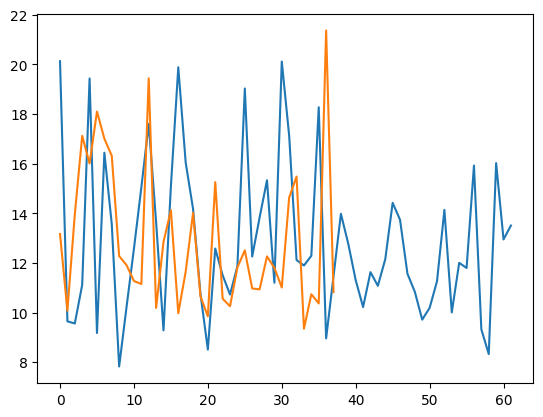

In [41]:
plt.plot([i.detach().numpy() for i in normal])
plt.plot([i.detach().numpy() for i in abnormal])

In [ ]:
from math import isnan
import ast

def safe_literal_eval(value):
    if isinstance(value, str) and 'nan' in value:
        value = value.replace('nan', '[]')
            
    if not isinstance(value, str) and isnan(value):
        return []
    return ast.literal_eval(value) if value else []

def ecg_annot_RR():
    annot = pd.read_csv('ecg_annotations.csv')

    qrs_peaks = safe_literal_eval(annot['channel_0_RR'][0])
    print(qrs_peaks)

    # return annot[['id', 'annot']]
    # 'channel_0_RR'

ecg_annot_RR()

[
